Lenet Test

In [1]:
import torch
import torch.nn as nn

class LeNet1(nn.Module):
    
    def __init__(self):
        super(LeNet1, self).__init__()
        
        # input is Nx1x28x28
        model_list = [
            # params: 4*(5*5*1 + 1) = 104
            # output is (28 - 5) + 1 = 24 => Nx4x24x24
            nn.Conv2d(1, 4, 5),
            nn.Tanh(),
            # output is 24/2 = 12 => Nx4x12x12
            nn.AvgPool2d(2),
            # params: (5*5*4 + 1) * 12 = 1212
            # output: 12 - 5 + 1 = 8 => Nx12x8x8
            nn.Conv2d(4, 12, 5),
            nn.Tanh(),
            # output: 8/2 = 4 => Nx12x4x4
            nn.AvgPool2d(2)
        ]
        
        self.model = nn.Sequential(*model_list)
        # params: (12*4*4 + 1) * 10 = 1930
        self.fc = nn.Linear(12*4*4, 10)
        self.criterion = nn.CrossEntropyLoss()
        
        # Total number of parameters = 104 + 1212 + 1930 = 3246
    
    def forward(self, x):
        out = self.model(x)
        out = out.view(x.size(0), -1)
        out = self.fc(out)
        return out

In [2]:
net = LeNet1()
params_num = 0
for parameter in net.parameters():
    print(parameter.size())
    print(parameter.view((-1,)).size())
    print()
    params_num += list(parameter.view((-1,)).size())[0]

print("Total Params number: {}".format(params_num))


torch.Size([4, 1, 5, 5])
torch.Size([100])

torch.Size([4])
torch.Size([4])

torch.Size([12, 4, 5, 5])
torch.Size([1200])

torch.Size([12])
torch.Size([12])

torch.Size([10, 192])
torch.Size([1920])

torch.Size([10])
torch.Size([10])

Total Params number: 3246


In [3]:
import numpy as np
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

full_train_set = torchvision.datasets.MNIST(root = "./data", train = True, download = True, transform=transform)
test_set = torchvision.datasets.MNIST(root = "./data", train = False, download = True, transform=transform)

val_set, train_set = torch.utils.data.random_split(full_train_set, (10000, len(full_train_set) - 10000))
mini_train_set, mini_val_set = torch.utils.data.random_split(full_train_set, (100, len(full_train_set) - 100))
mini_val_set = torch.utils.data.Subset(mini_val_set, np.arange(0, 20))

100.1%Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw
0.0%Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz to ./data/MNIST/raw/train-labels-idx1-ubyte.gz
113.5%Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw
100.4%Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw
180.4%Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


tensor(1.)
tensor(-1.)


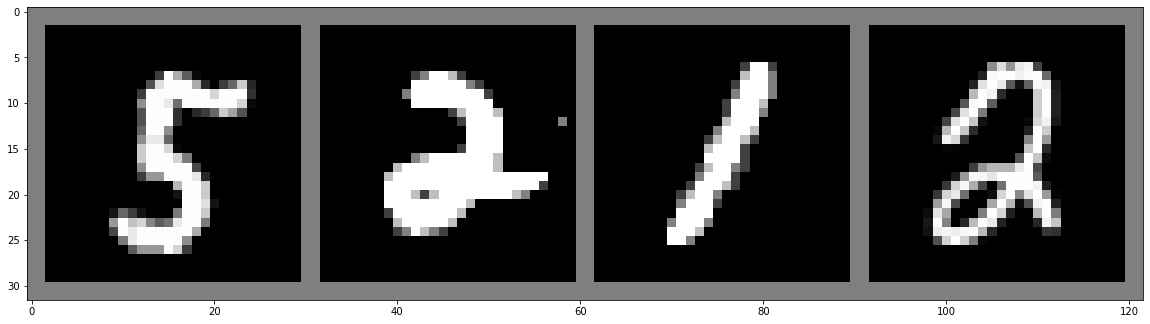

tensor(5) tensor(2) tensor(1) tensor(2)


In [4]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 15.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

tmploader = torch.utils.data.DataLoader(dataset = mini_train_set, shuffle = True, batch_size = 4, num_workers = 2)
dataiter = iter(tmploader)
images, labels = dataiter.next()

print(torch.max(images))
print(torch.min(images))

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j] for j in range(images.size(0))))

In [5]:
%load_ext autoreload
%autoreload 2

from src.solver import Solver
import torch.optim as optim

learning_rate = 0.01

net = LeNet1()
optimizer = optim.SGD(net.parameters(), lr=learning_rate)

options = {
    "train_data_loader": {
        "shuffle": True,
        "batch_size": 16,
        "num_workers": 4
    },
    "val_data_loader": {
        "shuffle": True,
        "batch_size": 16,
        "num_workers": 4
    },
    "back_up_model_every": 100,
    "epochs": 250
}

solver = Solver(net, mini_train_set, mini_val_set, **options)
solver.train(optimizer)

ModuleNotFoundError: No module named 'src'

In [ ]:
def box_smooth(data, length):
    box = np.ones(length)/length
    smooth_data = np.convolve(data, box, mode="same")
    return smooth_data

train_val_loss_ratio = torch.div(torch.tensor(solver.train_loss_history), torch.tensor(solver.val_loss_history))

sma_len = 3

plt.plot(box_smooth(solver.train_loss_history, sma_len), '-o')
plt.plot(box_smooth(solver.val_loss_history, sma_len), '-o')
plt.plot(box_smooth(train_val_loss_ratio, 10))
plt.legend(['train', 'val', 'train/val loss ratio'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
%load_ext autoreload
%autoreload 2

from src.solver import Solver
import torch.optim as optim

learning_rate = 0.01

net = LeNet1()
optimizer = optim.SGD(net.parameters(), lr=learning_rate)

options = {
    "train_data_loader": {
        "shuffle": True,
        "batch_size": 64,
        "num_workers": 3
    },
    "val_data_loader": {
        "shuffle": True,
        "batch_size": 64,
        "num_workers": 3
    },
    "back_up_model_every": 50,
    "epochs": 300
}

solver = Solver(net, train_set, val_set, **options)
solver.train(optimizer)


In [ ]:
chkpt = torch.load("./backups/0.01_last_300.pth")

options2 = {
    "train_data_loader": {
        "shuffle": True,
        "batch_size": 64,
        "num_workers": 3
    },
    "val_data_loader": {
        "shuffle": True,
        "batch_size": 64,
        "num_workers": 3
    },
    "back_up_model_every": 50,
    "epochs": 100
}

net2 = LeNet1()
net2.load_state_dict(chkpt["model_state"])
optimizer2 = optim.SGD(net2.parameters(), lr=learning_rate)
optimizer2.load_state_dict(chkpt["optimizer_state"])

solver2 = Solver(net2, train_set, val_set, **options2)
solver2.train_loss_history = chkpt["train_loss"]
solver2.val_loss_history = chkpt["val_loss"]

solver2.train(optimizer, start_i=300)

In [ ]:
plt.plot(solver2.train_loss_history[-100:], '-o')
plt.plot(solver2.val_loss_history[-100:], '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()



In [ ]:
chkpt = torch.load("./backups/0.01_300_300.pth")

options3 = {
    "train_data_loader": {
        "shuffle": True,
        "batch_size": 64,
        "num_workers": 3
    },
    "val_data_loader": {
        "shuffle": True,
        "batch_size": 64,
        "num_workers": 3
    },
    "back_up_model_every": 0,
    "epochs": 100
}

net3 = LeNet1()
net3.load_state_dict(chkpt["model_state"])
optimizer3 = optim.SGD(net3.parameters(), lr=.0001)
optimizer3.load_state_dict(chkpt["optimizer_state"])

solver3 = Solver(net3, train_set, val_set, **options3)
solver3.train_loss_history = chkpt["train_loss"]
solver3.val_loss_history = chkpt["val_loss"]

In [ ]:
plt.plot(solver3.train_loss_history[100:], '-o')
plt.plot(solver3.val_loss_history[100:], '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch (add 100. Starts with epoch=100, not epoch=0)')
plt.ylabel('loss')
plt.show()

In [ ]:
chkpt = torch.load("./backups/0.01_300_300.pth")

loader_opts = {
    "batch_size": 64,
    "num_workers": 6
}
final_loader = torch.utils.data.DataLoader(dataset = test_set, **loader_opts)

final_model = LeNet1()
final_model.load_state_dict(chkpt["model_state"])
final_model.eval()

train_acc = -1
with torch.no_grad():
    correct = 0
    total = 0

    for (inputs, labels) in final_loader:
        out = final_model(inputs)
        predicted = torch.argmax(out.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

final_acc = correct / total

print("Trained model prediction accuracy: {}%".format(final_acc * 100))


In [ ]:
misclassified_count = np.zeros(10, dtype=np.uint)
misclassified_imgs = [[] for i in np.arange(10)]
wrong_predicted_labels = [[] for i in np.arange(10)]

with torch.no_grad():
    for (inputs, labels) in final_loader:
        out = final_model(inputs)
        predicted = torch.argmax(out.data, 1)
        misclassified_indexes = predicted != labels
        
        miss_imgs = inputs[misclassified_indexes]
        correct_labels = labels[misclassified_indexes]
        wrong_pred_labels = predicted[misclassified_indexes]
        
        for (img, label, wrong_label) in zip(miss_imgs, correct_labels, wrong_pred_labels):
            misclassified_count[label.item()] += 1
            misclassified_imgs[label.item()].append(img.numpy())
            wrong_predicted_labels[label.item()].append(wrong_label.item())


# show images
subset_wrong_labels = np.array([wrong_predicted_labels[i][0:4] for i in np.arange(10)])
subset_imgs = torch.from_numpy(np.array([misclassified_imgs[i][0:4] for i in np.arange(10)]))
subset_imgs = subset_imgs.view((-1, 1, 28, 28))
imshow(torchvision.utils.make_grid(subset_imgs, nrow=4))
print(subset_wrong_labels)